In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Yeast

/content/drive/MyDrive/Yeast


In [3]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import load_model

In [4]:
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
lr = 1e-4
epochs = 100
height = 1536
width = 1536
batch_size = 1


In [11]:
dataset_path = os.path.join("dataset","non-aug")
files_dir = os.path.join("files","non-aug")

model_file = os.path.join(files_dir,"unet-non-aug.h5")
log_file = os.path.join(files_dir, "log-non-aug.csv")

In [12]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
create_dir(files_dir)

### *Building Unet*

In [13]:
def pad_image(img_path_array, target_size):
  for img_path in img_path_array:
    image = cv2.imread(img_path)
    H, W = image.shape[:2]
    target_H, target_W = target_size

    pad_height = max(0, target_H - H)
    pad_width = max(0, target_W - W)

    padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')

    padded_image = padded_image[:target_H, :target_W, :]
    cv2.imwrite(img_path, padded_image)

Conv Block

In [14]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters,3,padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

Encoder Block

In [15]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D(2, 2)(x)
    return x,p

Decoder Block

In [16]:
def decoder_block(input_tensor, concat_tensor, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
    concat_tensor = tf.image.resize_with_crop_or_pad(concat_tensor, tf.shape(x)[1], tf.shape(x)[2])
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

UNET

In [17]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2,256)
    s4, p4 = encoder_block(p3,512)

    """ Bridge """
    b1 = conv_block(p4, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs,outputs, name = "UNET")

    return model

Dataset Pipeline

In [18]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train", "images", "*")))
    train_y = sorted(glob(os.path.join(path, "train", "mask", "*")))

    valid_x = sorted(glob(os.path.join(path, "valid", "images", "*")))
    valid_y = sorted(glob(os.path.join(path, "valid", "mask", "*")))

    return (train_x,train_y), (valid_x,valid_y)

Reading Img

In [9]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    #image = tf.image.resize_with_crop_or_pad(image, [new_height, new_width], method=tf.image.ResizeMethod.BICUBIC)
    image = tf.cast(image, tf.float32) / 255.0
    return image

Readin Mask

In [19]:
def read_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    #mask = tf.image.resize_with_crop_or_pad(mask, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.float32) / 255.0
    return mask

tf.data pipeline

In [20]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x,y

    x,y = tf.numpy_function(_parse,[x,y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    return x, y

In [21]:
def tf_dataset(x, y , batch = 5):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

Training

In [22]:
(train_x, train_y),(valid_x, valid_y) = load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 35 - 35
Valid: 5 - 5


In [ ]:
pad_image(valid_x, (height, width))
pad_image(train_x, (height, width))
pad_image(train_y, (height, width))
pad_image(valid_y, (height, width))

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [ ]:
for x, y in valid_dataset:
    print(x.shape, y.shape)

(1, 1536, 1536, 3) (1, 1536, 1536, 1)
(1, 1536, 1536, 3) (1, 1536, 1536, 1)
(1, 1536, 1536, 3) (1, 1536, 1536, 1)
(1, 1536, 1536, 3) (1, 1536, 1536, 1)
(1, 1536, 1536, 3) (1, 1536, 1536, 1)


In [ ]:
input_shape = (height, width, 3)
model = build_unet(input_shape)

In [ ]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1536, 1536, 3)]      0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1536, 1536, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 1536, 1536, 64)       256       ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 1536, 1536, 64)       0         ['batch_normalization_1[0][

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [ ]:
opt = tf.keras.optimizers.Adam(lr) # Use tf.keras.optimizers instead of tf.keras.optimizer
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=False)
]

In [ ]:
model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = epochs,
    callbacks = callbacks
)

Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 0.4925 - mean_io_u: 0.4902
Epoch 1: val_loss improved from inf to 0.64903, saving model to files/non-aug/unet-non-aug.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 153s 2s/step - loss: 0.4925 - mean_io_u: 0.4902 - val_loss: 0.6490 - val_mean_io_u: 0.4897 - lr: 1.0000e-04
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 0.2272 - mean_io_u: 0.4902
Epoch 2: val_loss did not improve from 0.64903
35/35 [==============================] - 53s 2s/step - loss: 0.2272 - mean_io_u: 0.4902 - val_loss: 0.6668 - val_mean_io_u: 0.4897 - lr: 1.0000e-04
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 0.1843 - mean_io_u: 0.4902
Epoch 3: val_loss did not improve from 0.64903
35/35 [==============================] - 50s 1s/step - loss: 0.1843 - mean_io_u: 0.4902 - val_loss: 0.6831 - val_mean_io_u: 0.4897 - lr: 1.0000e-04
Epoch 4/100
35/35 [==============================] - ETA: 0s - loss: 0.1658 - mean_io_u: 0.4902
Epoch 4: val_loss improved from 0.64903 to 0.63344, saving model to files/non-aug/unet-non-aug.h5
35/35 [==============================] - 53s 2s/step - loss: 0.1658 - mean_

### *Load thử model dự đoán mask của ảnh train*

In [39]:
test = load_model("files/non-aug/unet-non-aug.h5")
test_folder = "saved/abnormal"
test_list = os.listdir(test_folder)

In [29]:
def pad_img(img, target_size):
    # Lấy kích thước hiện tại của ảnh
    h, w = img.shape[:2]

    # Tính toán số lượng padding cần thiết
    pad_h = max(0, (target_size[0] - h) // 2)
    pad_w = max(0, (target_size[1] - w) // 2)

    ex1 = (target_size[0] - h) % 2
    ex2 = (target_size[1] - w) % 2
    # Pad ảnh sao cho kích thước đạt target_size
    padded_img = cv2.copyMakeBorder(
        img,
        pad_h, pad_h + ex1, pad_w, pad_w +ex2,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )

    # Cắt ảnh nếu kích thước vượt quá target_size sau padding
    padded_img = padded_img[:target_size[0], :target_size[1]]

    return padded_img

In [37]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = pad_img(image, (1536, 1536))
    #image = tf.image.resize_with_crop_or_pad(image, [new_height, new_width], method=tf.image.ResizeMethod.BICUBIC)
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [40]:
test_images = []
for f in test_list:
    image_path = os.path.join(test_folder, f)
    image = read_image(image_path) # Call read_image for each image path
    test_images.append(image)

test_images = np.array(test_images)

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'copyMakeBorder'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
data_test = "BackTest/2h"
output_dir = "BackTest/mask2h"
os.makedirs(output_dir, exist_ok=True)
batch_size = 1
predictions = []
for i in range(0, len(test_images), batch_size):
    batch_predictions = test.predict(test_images[i:i+batch_size])
    predictions.extend(batch_predictions)

predictions = np.array(predictions)

# Hiển thị và lưu các ảnh và mask dự đoán tương ứng
for i in range(len(test_files)):
    plt.figure(figsize=(10, 5))

    # Ảnh gốc
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i])
    plt.title("Original Image")

    # Mask dự đoán
    plt.subplot(1, 2, 2)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    output_file = os.path.join(output_dir, os.path.basename(test_files[i]))
    plt.imsave(output_file, predictions[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")

    plt.show()

In [ ]:
test_files

['F1-B1-2h-10.jpeg',
 'F1-B1-2h-12.jpeg',
 'F1-B1-2h-03.jpeg',
 'F1-B1-2h-05.jpeg',
 'F1-B1-2h-02.jpeg',
 'F1-B1-2h-01.jpeg',
 'F1-B1-2h-08.jpeg',
 'F1-B1-2h-04.jpeg',
 'F1-B1-2h-07.jpeg',
 'F1-B1-2h-09.jpeg',
 'F1-B1-2h-06.jpeg',
 'F1-B1-2h-11.jpeg']

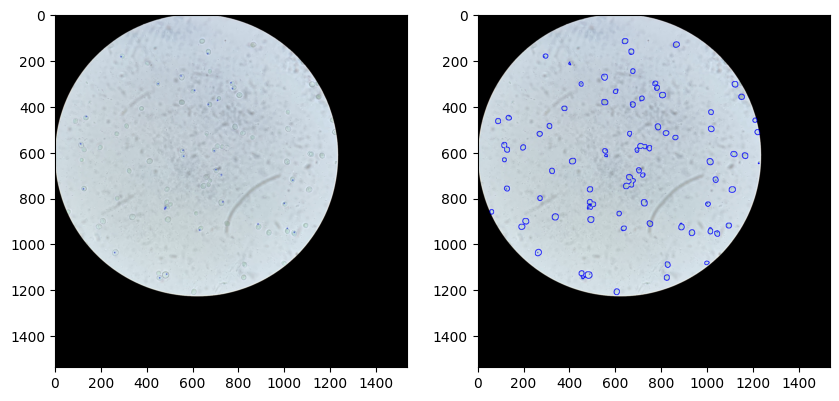

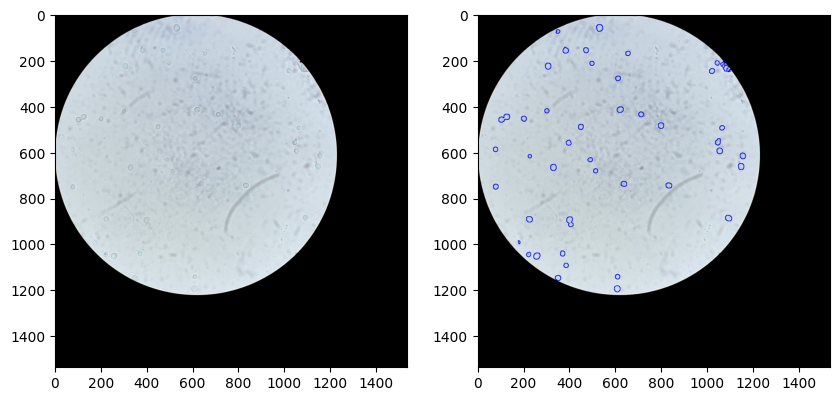

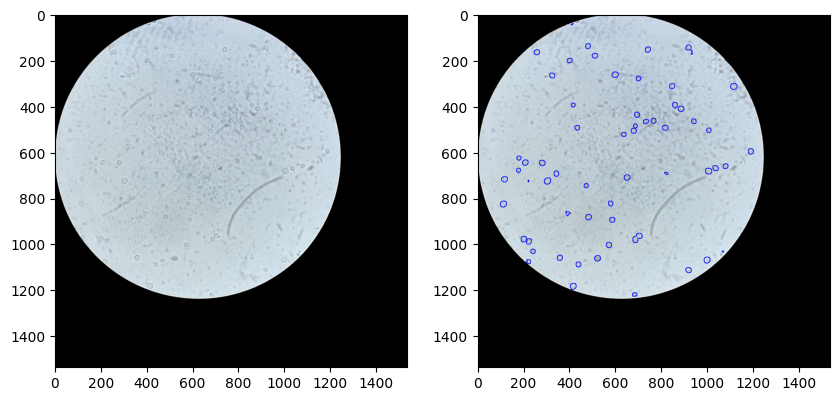

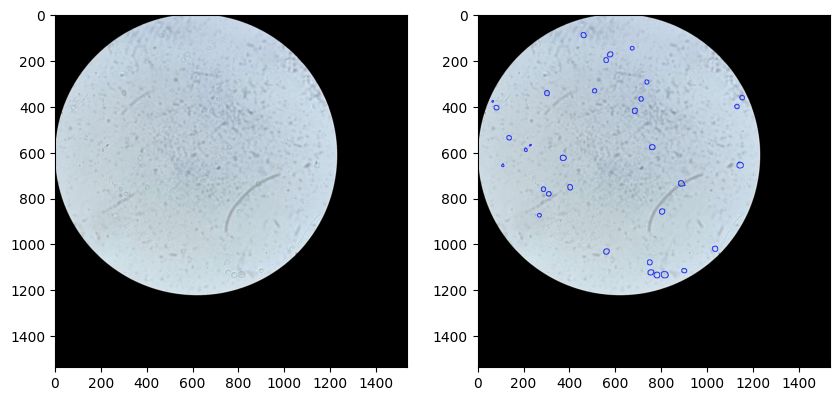

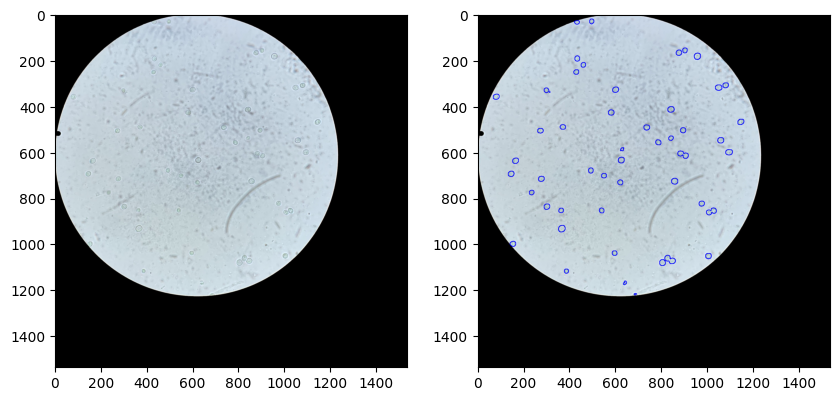

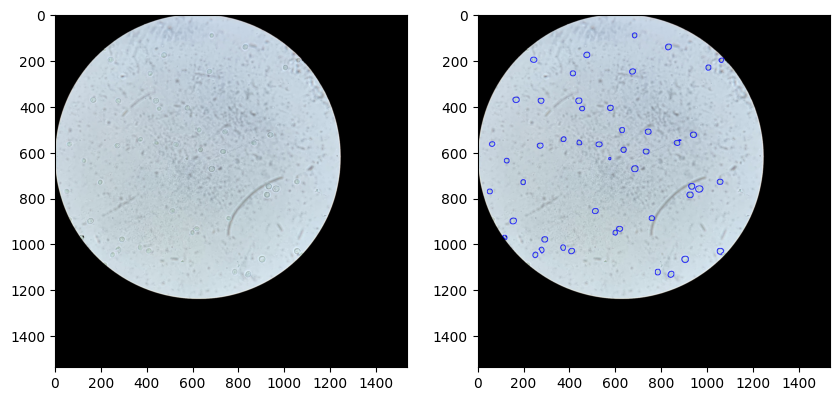

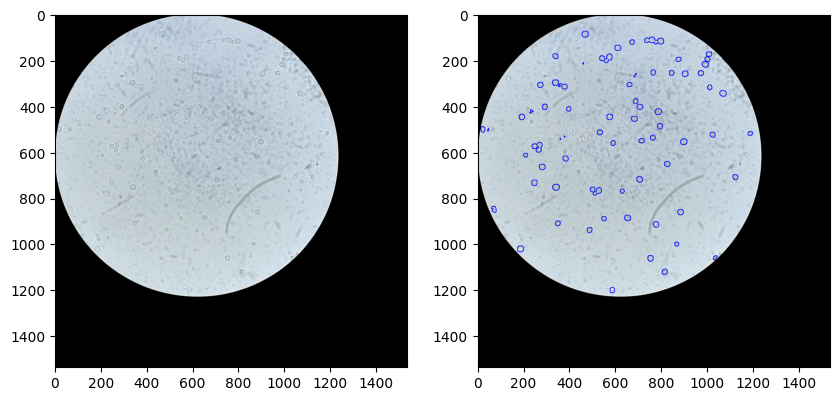

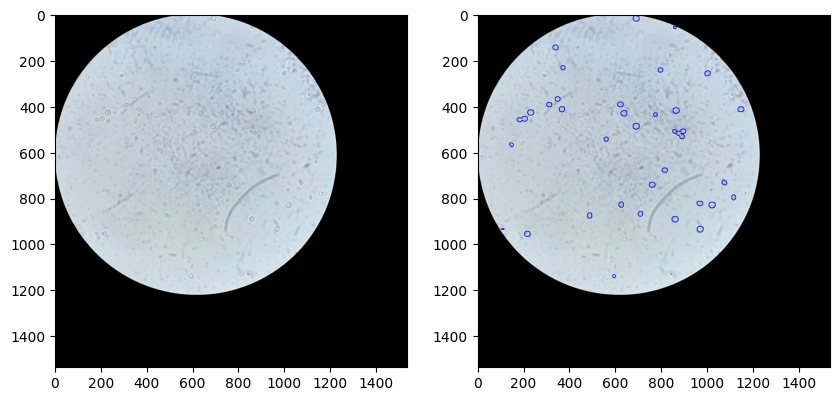

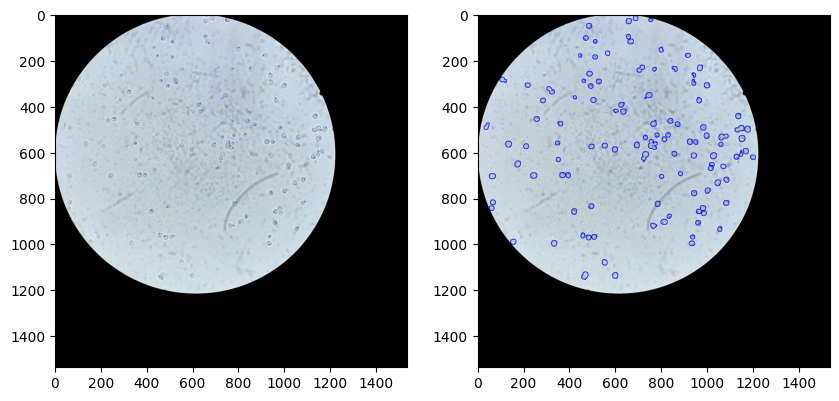

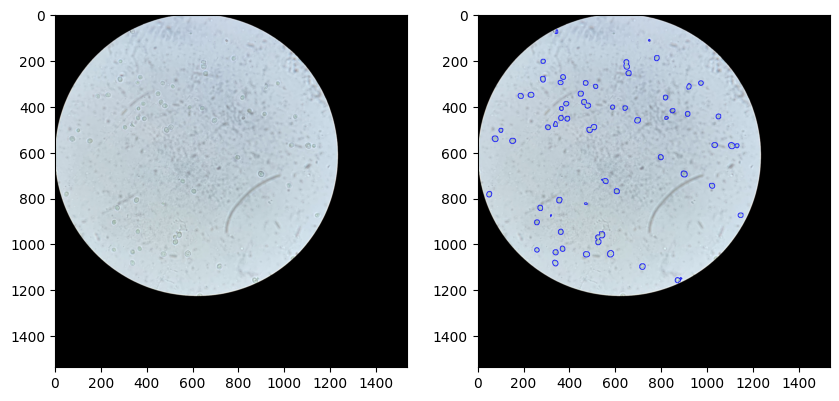

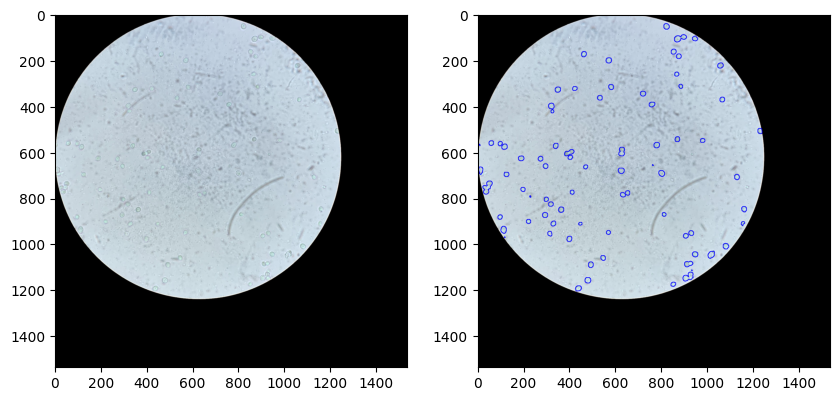

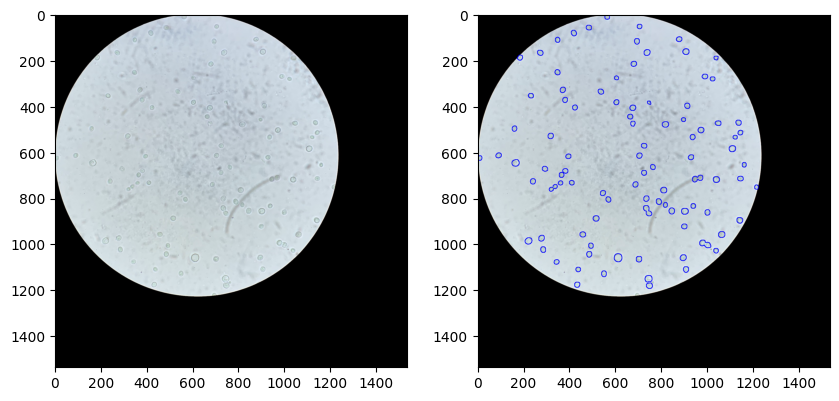

In [ ]:
MIN_WIDTH = 4
MAX_HEIGHT = height / 2

for ip in test_files:
  image = cv2.imread(os.path.join(data_test,ip))
  mask = cv2.imread(os.path.join("BackTest/mask2h",ip), cv2.IMREAD_GRAYSCALE)
  # plt.figure(figsize=(10, 5))
  # plt.imshow(image)
  # plt.show()
  # plt.figure(figsize=(10, 5))
  _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
  # plt.imshow(mask, cmap='gray')
  # plt.show()

  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w >= MIN_WIDTH and h < MAX_HEIGHT and h > MIN_WIDTH:
      cv2.drawContours(image, [cnt], -1, (0, 0, 255), 2)

  plt.subplot(1, 2, 2)
  plt.imshow(image)
  cv2.imwrite(os.path.join("BackTest/drawContours", ip), image)
  plt.show()




### *Test thử Unet++ BackBone*

In [ ]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip install -U segmentation-models

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!pip install --upgrade segmentation-models

In [ ]:
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.2.1
ERROR: Could not find a version that satisfies the requirement keras==2.5 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2,

In [ ]:
callbacks2 = [
    ModelCheckpoint(model_file + ".keras", verbose=1, save_best_only=True),  # Add '.keras' to the filename
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=False)
]

In [ ]:
import tensorflow as tf
from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

# Chọn backbone và kích thước đầu vào
BACKBONE = 'resnet34'
preprocess_input = tf.keras.applications.resnet.preprocess_input
input_shape = (1536, 1536, 3)

# Xây dựng mô hình U-Net++
model2 = Unet(BACKBONE, input_shape=input_shape, encoder_weights='imagenet', classes=1, activation='sigmoid')

# Compile mô hình với các metric IOU và Dice
model2.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])
model2.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = epochs,
    callbacks= callbacks2
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - iou_score: 0.0371 - loss: 1.6170
Epoch 1: val_loss improved from inf to 1.20542, saving model to files/non-aug/unet-non-aug.h5.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 109s 720ms/step - iou_score: 0.0376 - loss: 1.6110 - val_iou_score: 0.0149 - val_loss: 1.2054 - learning_rate: 0.0010
Epoch 2/100


KeyboardInterrupt: 

### *Dự đoán tập test*

In [ ]:
test_path = "BackTest/2h"
test_files = sorted(glob(os.path.join(test_path, "*")))